# Unit 4 Capstone - News Article Analysis & Classification

## John A. Fonte

---
---

### Instructions

1. Find 100 different entries from at least 10 different authors (articles?)
2. Reserve 25% for test set
3. cluster vectorized data (go through a few clustering methods)
4. Perform unsupervised feature generation and selection
5. Perform supervised modeling by classifying by author
6. Comment on your 25% holdout group. Did the clusters for the holdout group change dramatically, or were they consistent with the training groups? Is the performance of the model consistent? If not, why?
7. Conclude with which models (clustering or not) work best for classifying texts.

---
---

### About the Dataset

__Source:__ https://archive.ics.uci.edu/ml/datasets/Reuter_50_50#

__Description:__ This is a subset of the [Reuters Corpus Volume 1 (RCV1)](https://scikit-learn.org/0.17/datasets/rcv1.html). Specifically, this subset consists of the top 50 authors by article proliferation, with a total of 100 articles per each author within the combined training and testing sets.

---
---
# 1. Data Load and Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
'''
Loading Data from Local Computer
Each author is a subfolder, and within each folder is a series of .txt files
The goal of this cell is to load all the contents of every subfolder into the 
DataFrame, while retaining the author designation for those works.
'''

from os import listdir

def multiple_file_load(file_directory):
    
    # identifying all author subfolders - appending them into list 
    
    authorlist = []
    textlist = []
    
    for author in listdir(file_directory):
        authorname = str(author)
        author_sub_directory = (file_directory + '/' + author) #author file path
    
    # identifying all files within each subfolder - 
    
        for filename in listdir(author_sub_directory):
            text_file_path = (author_sub_directory + '/' + filename) # text file path
            
            if (filename.lower().endswith('txt')):
                authorlist.append(authorname)
                textfile = open(text_file_path,'r') # this is how you open files
                substantive_text = textfile.read()  # this is how to read a file
                textlist.append(substantive_text)   # this is how to do something with that file
                textfile.close()                    # this is how to close the file 
                                                             # (you must close one before opening another!)
  # pushing the two lists into a dataframe 

    df = pd.DataFrame({'Author':authorlist, 'Text':textlist})
    
    return df
                

In [3]:
# loading training data (note the file path)
df_train = multiple_file_load('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/C50/C50train')

In [4]:
df_train.head()

,Author,Text
0,AaronPressman,The Internet may be overflowing with new techn...
1,AaronPressman,The U.S. Postal Service announced Wednesday a ...
2,AaronPressman,Elementary school students with access to the ...
3,AaronPressman,An influential Internet organisation has backe...
4,AaronPressman,An influential Internet organisation has backe...


In [5]:
len(df_train)

2500

In [6]:
# adding the space in the authors...because I want it
import re

In [7]:
author_split = [re.findall('[A-Z][a-z]*', i) for i in df_train.Author]

In [8]:
author_split[:5]

[['Aaron', 'Pressman'],
 ['Aaron', 'Pressman'],
 ['Aaron', 'Pressman'],
 ['Aaron', 'Pressman'],
 ['Aaron', 'Pressman']]

In [9]:
#joining them back together
author_join = []

for couple in author_split:
    joined_string = couple[0] + ' ' + couple[1]
    author_join.append(joined_string)    

In [10]:
df_train['Author'] = pd.Series(author_join)
df_train.tail()

,Author,Text
2495,William Kazer,China's central bank chief has said that infla...
2496,William Kazer,"China ushered in 1997, a year it has hailed as..."
2497,William Kazer,China issued tough new rules on the handling o...
2498,William Kazer,China will avoid bold moves in tackling its ai...
2499,William Kazer,Communist Party chief Jiang Zemin has put his ...


In [11]:
# Before I begin adding features, assignment asks for 25% data split, NOT 50/50
# Going to have to concat some of those testing articles
df_test = multiple_file_load('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/C50/C50test')
df_test.head()

,Author,Text
0,AaronPressman,U.S. Senators on Tuesday sharply criticized a ...
1,AaronPressman,Two members of Congress criticised the Federal...
2,AaronPressman,Commuters stuck in traffic on the Leesburg Pik...
3,AaronPressman,A broad coalition of corporations went to Capi...
4,AaronPressman,"On the Internet, where new products come and g..."


In [12]:
#another fix to Author column

author_split = [re.findall('[A-Z][a-z]*', i) for i in df_test.Author]

author_join = []

for couple in author_split:
    joined_string = couple[0] + ' ' + couple[1]
    author_join.append(joined_string)    
    
df_test['Author'] = pd.Series(author_join)

In [13]:
'''GOAL:
Trying to get half of the datapoints OF EACH AUTHOR
in the testing set into a new DataFrame, which
will be concatenated onto the training set.
I will delete that from the testing set later.

Doing this instead of combining both and splitting 75/25 later 
ensures balanced data between the authors.
'''

def appendingdataframe(dataframe):
    appendabledataframe = pd.DataFrame(columns=['Author', 'Text'])
    
    for item in dataframe.Author.unique():
        print("Looping through ", item)
        df_testauthor = df_test[df_test['Author'] == item].copy() 
        appendabledataframe = appendabledataframe.append(df_testauthor[25:], 
                                                         ignore_index=True) # want half of df_testauthor!
    
    return appendabledataframe
    

In [14]:
# using appendabledataframe to avoid screwing up original data
# This is explicit inefficiency at the cost of being cautious

df_train2 = df_train.append(appendingdataframe(df_train), ignore_index=True)

Looping through  Aaron Pressman
Looping through  Alan Crosby
Looping through  Alexander Smith
Looping through  Benjamin Kang
Looping through  Bernard Hickey
Looping through  Brad Dorfman
Looping through  Darren Schuettler
Looping through  David Lawder
Looping through  Edna Fernandes
Looping through  Eric Auchard
Looping through  Fumiko Fujisaki
Looping through  Graham Earnshaw
Looping through  Heather Scoffield
Looping through  Jane Macartney
Looping through  Jan Lopatka
Looping through  Jim Gilchrist
Looping through  Joe Ortiz
Looping through  John Mastrini
Looping through  Jonathan Birt
Looping through  Jo Winterbottom
Looping through  Karl Penhaul
Looping through  Keith Weir
Looping through  Kevin Drawbaugh
Looping through  Kevin Morrison
Looping through  Kirstin Ridley
Looping through  Kourosh Karimkhany
Looping through  Lydia Zajc
Looping through  Lynne O
Looping through  Lynnley Browning
Looping through  Marcel Michelson
Looping through  Mark Bendeich
Looping through  Martin Wolk

In [15]:
# checking if the appending worked
len(df_train2)

3750

In [16]:
df_train = df_train2.copy()

In [17]:
# doing same for df_test

df_test2 = df_test.append(appendingdataframe(df_train), ignore_index=True)

# checking if the appending worked
len(df_test2)

Looping through  Aaron Pressman
Looping through  Alan Crosby
Looping through  Alexander Smith
Looping through  Benjamin Kang
Looping through  Bernard Hickey
Looping through  Brad Dorfman
Looping through  Darren Schuettler
Looping through  David Lawder
Looping through  Edna Fernandes
Looping through  Eric Auchard
Looping through  Fumiko Fujisaki
Looping through  Graham Earnshaw
Looping through  Heather Scoffield
Looping through  Jane Macartney
Looping through  Jan Lopatka
Looping through  Jim Gilchrist
Looping through  Joe Ortiz
Looping through  John Mastrini
Looping through  Jonathan Birt
Looping through  Jo Winterbottom
Looping through  Karl Penhaul
Looping through  Keith Weir
Looping through  Kevin Drawbaugh
Looping through  Kevin Morrison
Looping through  Kirstin Ridley
Looping through  Kourosh Karimkhany
Looping through  Lydia Zajc
Looping through  Lynne O
Looping through  Lynnley Browning
Looping through  Marcel Michelson
Looping through  Mark Bendeich
Looping through  Martin Wolk

3750

In [18]:
# and now to drop the rows added to df_train from df_test

df_test2.drop_duplicates(keep=False, inplace=True)
len(df_test2)

1250

In [19]:
df_test = df_test2.copy()

In [20]:
# quick cleaning of the text before jumpring into feature engineering
def text_cleaner(text):
    text = re.sub('.\n.', '. .', text)
    text = re.sub(r'--', ' ', text)
    text = re.sub(r'  ', ' ', text)
    text = re.sub('[\[].*?[\]]', '', text)
    text = re.sub('.=.', '. .', text)
    text = text.lower() # avoiding capitalization problems.
    
    return text

In [21]:
# quick cleaning of text:

df_train['Text'] = df_train['Text'].apply(lambda x: text_cleaner(x))
df_test['Text'] = df_test['Text'].apply(lambda x: text_cleaner(x))

---

# Adding Features

Just some fun numerical features!

In [22]:
# adding some numerical features for text analysis

df_train['Raw Character Count'] = df_train['Text'].apply(lambda x: len(x))
df_train['Raw Word Count'] = df_train['Text'].apply(lambda x: len(x.split()))

In [23]:
# doing same for df_test

df_test['Raw Character Count'] = df_test['Text'].apply(lambda x: len(x))
df_test['Raw Word Count'] = df_test['Text'].apply(lambda x: len(x.split()))

In [24]:
# creating numerical classes for authors:
# I feel like one hot encoding would've screwed things up, so I did "factorize"

df_train['AuthorNum'] = pd.factorize(df_train.Author)[0]
df_train['AuthorNum'] = df_train['AuthorNum'].astype("category")

In [25]:
df_train.tail()

,Author,Text,Raw Character Count,Raw Word Count,AuthorNum
3745,William Kazer,china has scored new successes in its fight ag...,2473,411,49
3746,William Kazer,china has scored new successes in its fight ag...,2473,411,49
3747,William Kazer,china is on target with plans to to promote 10...,1742,287,49
3748,William Kazer,china may need to adjust the mix of its treasu...,3261,545,49
3749,William Kazer,a chinese ideologue known for his strictly ort...,3022,481,49


In [26]:
# and same for df_test...

df_test['AuthorNum'] = pd.factorize(df_test.Author)[0]
df_test['AuthorNum'] = df_test['AuthorNum'].astype("category")

In [27]:
df_test.tail()

,Author,Text,Raw Character Count,Raw Word Count,AuthorNum
2470,William Kazer,china's foreign minister qian qichen on friday...,1827,299,49
2471,William Kazer,china blamed criminal elements on sunday for a...,3156,516,49
2472,William Kazer,an unemployed taiwanese journalist on monday d...,3000,492,49
2473,William Kazer,china moved ahead on wednesday with plans to h...,3762,590,49
2474,William Kazer,premier li peng said on friday china wanted a ...,2417,408,49


# Vectorizing! Changing Text to Numbers

Once everything is numerical, then we can feed that data into the clusters for analysis.

In [33]:
# doing tokenization (unigram), lemmatization, and stop_word exclusion
# ***AS PART**** of the model, not a separate spacy thing

import spacy
nlp = spacy.load('en')

In [39]:
df_train['Spacy-ed Text'] = df_train['Text'].apply(lambda text: nlp(text))
df_test['Spacy-ed Text'] = df_test['Text'].apply(lambda text: nlp(text))

In [41]:
# setting up function to (1) lemmatize AND
# (2) exclude stop words from the count

from collections import Counter

def lemma_frequencies(text, include_stop=True):
    
    # Build a list of lemmas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_) # this is why we needed to spacy/nlp-ify the texts first
            
    # Build and return a Counter object containing word counts.
    return Counter(lemmas)

df_train['Meaningful Word Count'] = df_train['Spacy-ed Text'].apply(lambda text: lemma_frequencies(text, 
                                                                                                   include_stop=False))
df_test['Meaningful Word Count'] = df_test['Spacy-ed Text'].apply(lambda text: lemma_frequencies(text,
                                                                                                include_stop=False))

In [42]:
# didn't want a dictionary. I wanted a total:

df_train['Meaningful Word Count Total'] = df_train['Meaningful Word Count'].apply(lambda x: sum(list(x.values())))
df_test['Meaningful Word Count Total'] = df_test['Meaningful Word Count'].apply(lambda x: sum(list(x.values())))

In [43]:
def lemmatize(text, include_stop=True):
    
    # Build a list of lemmas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_) # this is why we needed to spacy/nlp-ify the texts first
            
    # Build and return a Counter object containing word counts.
    return lemmas

In [46]:
df_train['Lemmatized Text'] = df_train['Spacy-ed Text'].apply(lambda text: lemmatize(text, include_stop=False))
df_test['Lemmatized Text'] = df_test['Spacy-ed Text'].apply(lambda text: lemmatize(text, include_stop=False))

In [48]:
df_test.head()

,Author,Text,Raw Character Count,Raw Word Count,AuthorNum,Spacy-ed Text,Meaningful Word Count,Meaningful Word Count Total,Lemmatized Text
0,Aaron Pressman,u.s. senators on tuesday sharply criticized a ...,3802,604,0,"(u.s, ., senators, on, tuesday, sharply, criti...","{'u.s': 1, 'senator': 2, 'tuesday': 3, 'sharpl...",341,"[u.s, senator, tuesday, sharply, criticize, ne..."
1,Aaron Pressman,two members of congress criticised the federal...,2158,349,0,"(two, members, of, congress, criticised, the, ...","{'member': 1, 'congress': 2, 'criticise': 1, '...",199,"[member, congress, criticise, federal, reserve..."
2,Aaron Pressman,commuters stuck in traffic on the leesburg pik...,6403,1048,0,"(commuters, stuck, in, traffic, on, the, leesb...","{'commuter': 1, 'stick': 1, 'traffic': 9, 'lee...",617,"[commuter, stick, traffic, leesburg, pike, nor..."
3,Aaron Pressman,a broad coalition of corporations went to capi...,2223,329,0,"(a, broad, coalition, of, corporations, went, ...","{'broad': 1, 'coalition': 1, 'corporation': 1,...",222,"[broad, coalition, corporation, go, capitol, h..."
4,Aaron Pressman,"on the internet, where new products come and g...",4227,690,0,"(on, the, internet, ,, where, new, products, c...","{'internet': 12, 'new': 1, 'product': 1, 'come...",389,"[internet, new, product, come, blink, eye, tim..."


In [49]:
# all processing is complete, saving it as a csv so I don't have to do it again


# commented out because this cell should only be run once

#df_train.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/COMPLETE_NLP-train.csv',
#                index=False)
#
#df_test.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/COMPLETE_NLP-test.csv',
#               index=False)

In [50]:
# creating output for vectors, i.e., 
# a NEW dataframe from a vectorized "word matrix"
def word_matrix_2_df(word_matrix, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(word_matrix)]
    
    df = pd.DataFrame(data=word_matrix.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [52]:
# now that tokens are created via lemmatization, we can vectorize those tokens

# FIRST VECTORIZER - BAG-OF-WORDS!!!!!!!!!!!

from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc

cv = CountVectorizer(
    tokenizer=dummy, # putting lemmatizer function in here would've thrown an error
    preprocessor=dummy,
)  

In [53]:
cwm = cv.fit_transform(list(df_train['Lemmatized Text']))
tokens = cv.get_feature_names()

df_train_vectorized = word_matrix_2_df(cwm, tokens)

In [54]:
df_train_vectorized

,,,,,,,,,,,...,zurich,zuyao,zuzana,zwanziger,zwetchenbaum,zwetchkenbaum,zx2,zygmunt,zyprexa,zyrtec
Doc0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df_train_vectorized.shape

(3750, 40197)

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def plot_coefficients(classifier, X_input, Y_input, feature_names, top_features=20):
    classifier.fit(X_input, Y_input)
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    
    plt.show()

C:\Anaconda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


IndexError: index 924553 is out of bounds for axis 0 with size 40197

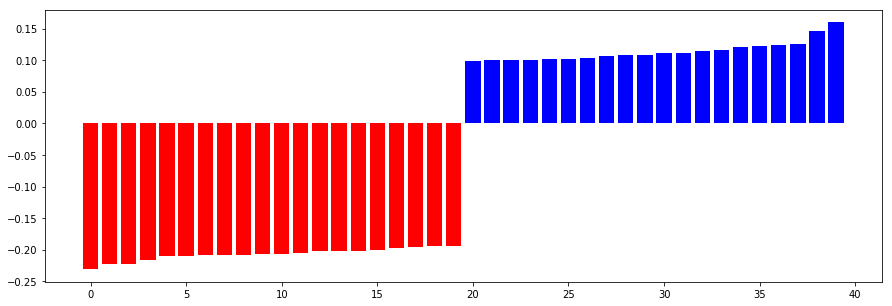

In [78]:
plot_coefficients(LinearSVC(max_iter=500), df_train_vectorized, df_train['AuthorNum'], tokens)

In [62]:
# setting classifer to Linear SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

AttributeError: 'SVC' object has no attribute 'dual_coef_'

In [91]:
# setting up analysis function

def printNMostInformative(classifier, X_input, Y_input, feature_names, N=20):
    classifier.fit(X_input, Y_input)
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
  

In [92]:
# obtain error (no dual.coef_)
printNMostInformative(SVC(kernel='linear', max_iter=100), df_train_vectorized, df_train['AuthorNum'], tokens)

C:\Anaconda\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Class 1 best: 
(-0.07857930203224768, 'czech')
(-0.05315014138821921, 'crown')
(-0.03673193037571186, 'win')
(-0.03288131347222915, 'market')
(-0.03086617933109487, '6')
(-0.03026747347604096, 'match')
(-0.028864290679510064, 'prague')
(-0.02778954788544531, 'second')
(-0.026408331455391176, 'billion')
(-0.025887877309088873, 'year')
(-0.02455271495037078, 'world')
(-0.024145065758803593, 'horse')
(-0.023721669407704433, 'round')
(-0.023150885386051593, 'set')
(-0.0228105410664899, 'banka')
(-0.022578874690482285, 'british')
(-0.02183996532469193, 'play')
(-0.020538653830010866, 'ipb')
(-0.019497771143303103, 'take')
(-0.01936533982019326, 'share')
Class 2 best: 
(0.04195708966544557, 'internet')
(0.027651477389861248, 'association')
(0.02285044330026717, 'insurance')
(0.020379949584601608, 'trademark')
(0.01905024875442702, 'export')
(0.018858014925659982, 'consumer')
(0.015503644899908872, 'school')
(0.015396569396200554, 'software')
(0.014961631266460003, 'information')
(0.014739676

In [ ]:
#-------------------------------------------------------------------------------------------
# NEW VECTORIZER - Tfidf!!!!!!!!

tfidf = TfidfVectorizer(analyzer=lambda x: x, ngram_range=(1,1))
tfidf_vectors = tfidf.fit_transform(df_train['Lemmatized Text'])

# save this commented-out thing for later?
# df_word_matrix_TRAIN = pd.DataFrame(tfidf_vectors.todense(), columns=tfidf.vocabulary_)

feature_names = tfidf_vectors.get_feature_names()
df_train_tfidf_vectorized = word_matrix_2_df(tfidf_vectors, feature_names)

# CLUSTERING ANALYSIS

Looking at which vectorized features are the biggest influencers 

In [ ]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [ ]:
y = df_train['AuthorNum']

X_norm = normalize(cluster_X_train)
X_pca = PCA(2).fit_transform(X_norm)

# PCA spreads data out (as a result of lower dimensionality, don't ask)
# Normalizing is just needed (don't ask) - it will throw a ValueError otherwise.

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y)) # pandas version of confusion_matrix
